In [45]:
# Import das Bibliotecas
from dotenv import load_dotenv
import psycopg
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

In [2]:
# Executa a função para carregar as variáveis do arquivo .env no ambiente
load_dotenv()

True

In [3]:
# Conexão com o banco de dados
def get_db_connection():
    """Cria e retorna uma conexão com o banco de dados."""
    try:
        conn = psycopg.connect(
            host="localhost",
            dbname=os.getenv("DB_NAME"),
            user=os.getenv("DB_USER"),
            password=os.getenv("DB_PASSWORD"),
            port=os.getenv("DB_PORT")
        )
        return conn
    except Exception as e:
        print(f"Erro ao conectar ao banco de dados: {e}")
        raise e

In [28]:
def converter_meses_para_portugues(df, coluna_mes):
    """
    Converte uma coluna de meses (números ou strings) para nomes em português.
    
    Args:
        df: DataFrame pandas.
        coluna_mes: Nome da coluna com os meses (números 1-12 ou strings).
    
    Returns:
        DataFrame com a coluna modificada e ordenada corretamente.
    """
    # Mapeamentos
    meses_de_numero = {
        1: 'Janeiro',
        2: 'Fevereiro',
        3: 'Março',
        4: 'Abril',
        5: 'Maio',
        6: 'Junho',
        7: 'Julho',
        8: 'Agosto',
        9: 'Setembro',
        10: 'Outubro',
        11: 'Novembro',
        12: 'Dezembro'
    }
    
    meses_de_ingles = {
        'January': 'Janeiro',
        'February': 'Fevereiro',
        'March': 'Março',
        'April': 'Abril',
        'May': 'Maio',
        'June': 'Junho',
        'July': 'Julho',
        'August': 'Agosto',
        'September': 'Setembro',
        'October': 'Outubro',
        'November': 'Novembro',
        'December': 'Dezembro'
    }
    
    # Verifica o tipo dos dados na coluna
    sample_value = df[coluna_mes].iloc[0] if len(df) > 0 else None
    
    if sample_value is not None:
        if isinstance(sample_value, (int, float)) and not pd.isna(sample_value):
            # Se for numérico
            df[coluna_mes] = df[coluna_mes].map(meses_de_numero)
        elif isinstance(sample_value, str):
            # Se for string, verifica se está em inglês
            if sample_value in meses_de_ingles:
                df[coluna_mes] = df[coluna_mes].map(meses_de_ingles)
            # Se já estiver em português, não faz nada
        else:
            raise ValueError("Formato de mês não reconhecido. Use números (1-12) ou nomes em inglês.")
    
    # Garante a ordem cronológica
    ordem_meses = list(meses_de_numero.values())
    df[coluna_mes] = pd.Categorical(
        df[coluna_mes],
        categories=ordem_meses,
        ordered=True
    )
    
    return df.sort_values(coluna_mes)

In [5]:
def execute_query(query, conn, cursor, return_df = True):
    conn.rollback() # Reinicia a transação (caso tenha alguma transação que tenha dado errado)

    cursor.execute(query)

    # Pegando os dados da consulta
    result = cursor.fetchall()

    # Pegando os nomes das colunas
    columns = cursor.description

    # Colocando o nome das colunas 
    df = [{columns[index][0]: column for index, column in enumerate(value)} for value in result]

    # Transformando de DataFrame para fazer o gráfico
    return pd.DataFrame(df)

In [6]:
# Estabelecendo a conexão
conn = get_db_connection()

# Estabelecendo o cursor para executar consultas
cursor = conn.cursor()

In [34]:
query = '''
        SELECT 
                ha.year_month AS ano_mes,
                ha.pollutant_code AS poluente,
                ha.state_code AS uf,
                ha.total_health_cases AS numero_total_casos,
                ha.monthly_avg_pollution AS media_poluicao
        FROM 
                gold.mart_health_vs_air_quality AS ha
        GROUP BY
                1, 2, 3, 4, 5
'''
df = execute_query(query, conn, cursor, True)

In [35]:
df

,ano_mes,poluente,uf,numero_total_casos,media_poluicao
0,2022-01,CO,BA,18085,0.36635808748728382503
1,2022-01,CO,ES,4066,1.1718008705114255
2,2022-01,CO,MG,70299,0.51170627615062761506
3,2022-01,CO,MS,11965,0.32635294117647058824
4,2022-01,CO,RJ,39821,0.43153687112336319779
...,...,...,...,...,...
351,2022-11,SO2,MG,16715,3.6248882681564246
352,2022-11,SO2,MS,3005,8.4784525547445255
353,2022-11,SO2,PR,14635,5.0425547730829421
354,2022-11,SO2,RS,5229,10.1058681672025723


In [36]:
# Converter para datetime e extrair o mês
df['ano_mes'] = pd.to_datetime(df['ano_mes'])
df['mes'] = df['ano_mes'].dt.month_name()

df.sort_values(by='mes')

,ano_mes,poluente,uf,numero_total_casos,media_poluicao,mes
93,2022-04-01,CO,BA,6044,0.25924086870681145114,April
94,2022-04-01,CO,ES,1862,1.3782532751091703,April
95,2022-04-01,CO,MG,15744,0.52646256646069837620,April
97,2022-04-01,CO,RJ,10169,0.45577720207253886010,April
98,2022-04-01,CO,RS,8479,1.7699646643109541,April
...,...,...,...,...,...,...
283,2022-09-01,SO2,RJ,6161,8.5811031518624642,September
284,2022-09-01,SO2,RS,6011,8.6379366650173182,September
285,2022-09-01,SO2,SP,32810,34.6781115879828326,September
270,2022-09-01,NO2,MS,2833,6.8925295926210607,September


In [37]:
df = converter_meses_para_portugues(df, coluna_mes='mes')

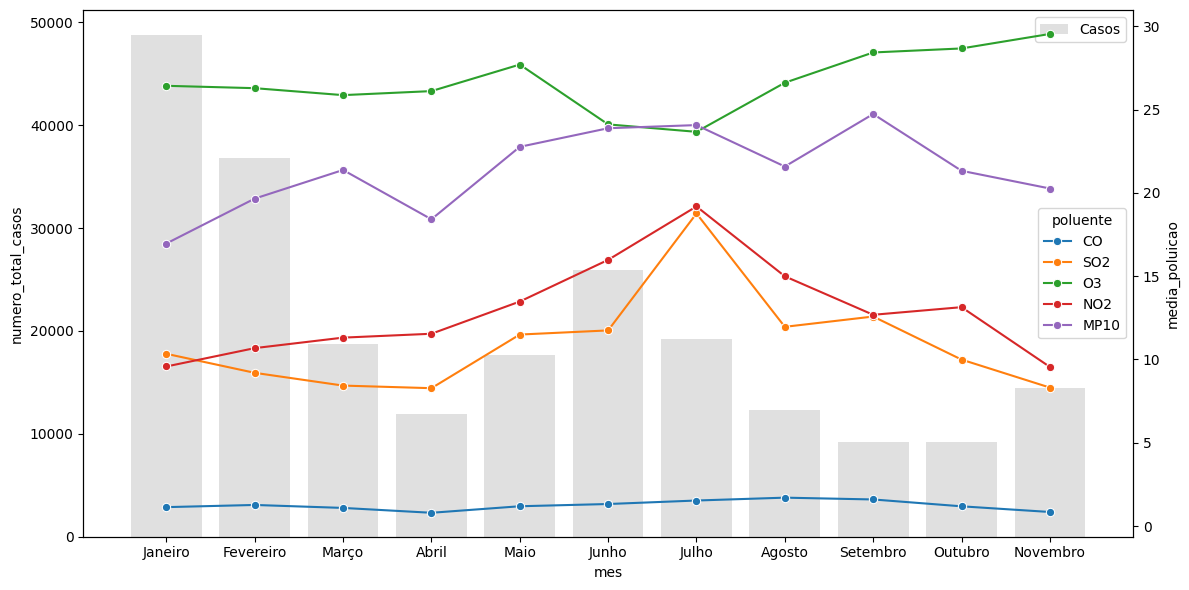

In [38]:
# Gráfico duplo: linha -> Sériel Temporal dos poluentes
#                barras -> número de casos
# Colocar filtros: estado e poluente para o gŕafico não ficar tão poluído
plt.figure(figsize=(12, 6))

sns.barplot(data=df, x='mes', y='numero_total_casos',color='lightgray', alpha=0.7, label='Casos', errorbar=None)
ax2 = plt.twinx()
sns.lineplot(data=df, x='mes', y='media_poluicao', hue='poluente', marker='o', errorbar=None)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [43]:
# Converter para numérico, forçando erros para NaN
df['media_poluicao'] = pd.to_numeric(df['media_poluicao'], errors='coerce')
df['numero_total_casos'] = pd.to_numeric(df['numero_total_casos'], errors='coerce')

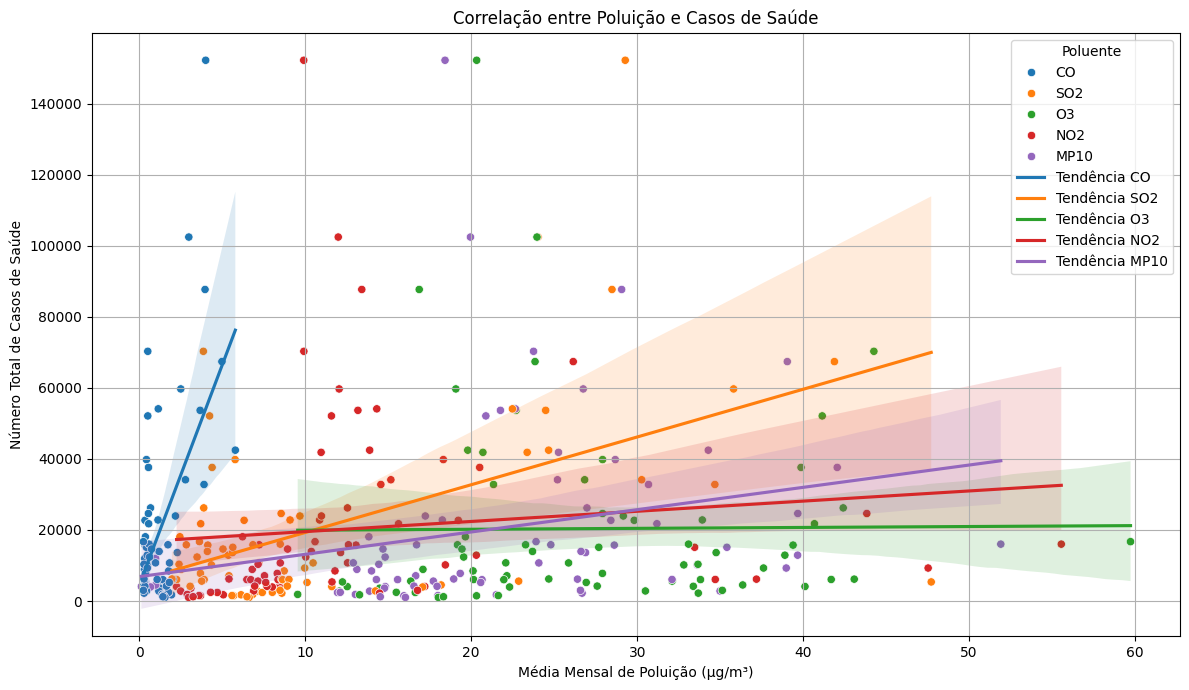

In [49]:
plt.figure(figsize=(12, 7))
sns.scatterplot(data=df, x='media_poluicao', y='numero_total_casos', hue='poluente')

# Adicionar linha de tendência manualmente (para cada poluente)
for poluente in df['poluente'].unique():
    subset = df[df['poluente'] == poluente]
    sns.regplot(data=subset, x='media_poluicao', y='numero_total_casos', 
               scatter=False, label=f'Tendência {poluente}')

plt.title('Correlação entre Poluição e Casos de Saúde')
plt.xlabel('Média Mensal de Poluição (µg/m³)')
plt.ylabel('Número Total de Casos de Saúde')
plt.legend(title='Poluente')
plt.grid(True)
plt.tight_layout()
plt.show()

In [46]:
fig = go.Figure()

for poluente in df['poluente'].unique():
    subset = df[df['poluente'] == poluente]
    
    # Adicionar pontos
    fig.add_trace(go.Scatter(
        x=subset['media_poluicao'],
        y=subset['numero_total_casos'],
        mode='markers',
        name=poluente,
        hovertext=subset.apply(lambda row: f"UF: {row['uf']}<br>Mês: {row['mes']}", axis=1)
    ))
    
    # Calcular regressão linear manualmente
    x = subset['media_poluicao'].values
    y = subset['numero_total_casos'].values
    coeffs = np.polyfit(x, y, 1)
    trendline = np.poly1d(coeffs)
    
    # Adicionar linha de tendência
    fig.add_trace(go.Scatter(
        x=x,
        y=trendline(x),
        mode='lines',
        name=f'Tendência {poluente}',
        line=dict(dash='dash')
    ))

fig.update_layout(
    title='Correlação entre Poluição e Casos de Saúde',
    xaxis_title='Média Mensal de Poluição (µg/m³)',
    yaxis_title='Número Total de Casos de Saúde',
    width=1000,
    height=600
)

fig.show()